In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr
import pandas as pd

import napari, qtpy, superqt
print("napari:", napari.__version__)
print("qtpy:", qtpy.__version__)
print("superqt:", superqt.__version__)

napari: 0.4.19.post1
qtpy: 2.4.0
superqt: 0.6.7


In [2]:
%gui qt
%config Completer.use_jedi = False  #magic to fix autocomplete issue

def view_image(*args, **kwargs):
    import napari
    viewer = napari.view_image(*args, **kwargs)
    viewer.window._qt_window.raise_()
    viewer.window._qt_window.activateWindow()
    viewer.window._qt_window.show()
    return viewer


In [3]:
from fly2p.viz.viz import *
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume
onCluster = False

### data details

In [90]:
# === Set root storage directory depending on environment ===
#storageDir = '/groups/otopaliklab' if onCluster else '/Volumes'
#rootDir = f'{storageDir}/otopaliklab/Aisha/Data'
rootDir = 'C:\\Users\\hamida\\Documents\\Data'


In [144]:
flyID = 'Fly_0006'
trial_folder = 'D'


dataDir = sep.join([rootDir, 'raw', flyID, trial_folder])
preprocDir = sep.join([rootDir, 'preproc', flyID, trial_folder])
plotDir = sep.join([rootDir, 'plot',flyID, trial_folder])
print(f'flyID: {flyID}, trial folder: {trial_folder}')
rawTiff = 'Fly_0006D_00001.tif'


flyID: Fly_0006, trial folder: D


In [145]:
tiff_path = sep.join([dataDir, rawTiff])
tiff_path

'C:\\Users\\hamida\\Documents\\Data\\raw\\Fly_0006\\D\\Fly_0006D_00001.tif'

In [146]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
SImetadict = getSIMetadict(mytiffreader.metadata())

SI.VERSION_COMMIT = 'b0e89ff7717e60826b56173afe65ddb1ea6efb87'
SI.VERSION_MAJOR = 2023
SI.VERSION_MINOR = 1
SI.VERSION_UPDATE = 0


In [147]:
basicMetadat["CaCh"] = 0 # give channel identity
# Load data: With larger file sizes, the scanimage loader fails (idk why)
stack = loadvolume(tiff_path, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

In [148]:
basicMetadat

{'nCh': 1,
 'fpsscan': 44.58544776119403,
 'discardFBFrames': 'true',
 'nDiscardFBFrames': 2,
 'fpv': 10,
 'nVols': 6000,
 'stackZStepSize': 3.0,
 'scanVolumeRate': 4.458544776119403,
 'fovCoords': {'p00': [-33.75000000000001, -33.75000000000001],
  'p10': [33.75000000000001, 33.75000000000001],
  'p01': [33.75000000000001, -33.75000000000001],
  'p11': [-33.75000000000001, 33.75000000000001]},
 'xrange_um': 67.50000000000001,
 'yrange_um': 67.50000000000001,
 'CaCh': 0}

In [149]:
imgStack.shape

(6000, 8, 512, 512)

### motion correction

C:\Users\hamida\AppData\Local\Temp\ipykernel_18360\4003581364.py:11: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


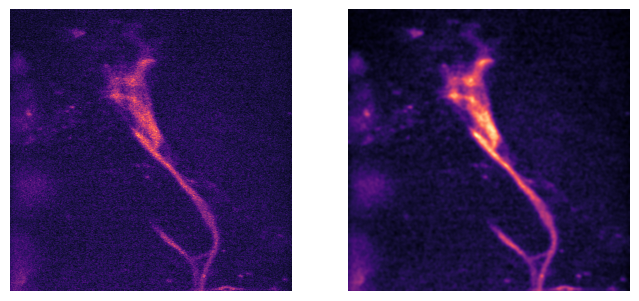

In [150]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over planes

numRefImg = 20
refstart = 100
locRefImg = round(stackMP['volumes [s]'].size/2)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0) + np.mean(stackMP[refstart:refstart+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='magma', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='magma', origin='lower'); axs[1].axis('off');

In [ ]:
# use this if you want to construct a ref image (for MC) just based on the average across volumes
# ref_Img_avg = np.mean(stackMP,axis=0)

In [151]:
stackMP.shape

(6000, 512, 512)

In [152]:
stackMP_fraction = stackMP[:8000]
stackMP_fraction.shape

(6000, 512, 512)

In [153]:
stackMP2 = stackMP_fraction

perform motion correction on a single plane/max projection
. . . . . . . . . . . . . . . . . . . . 

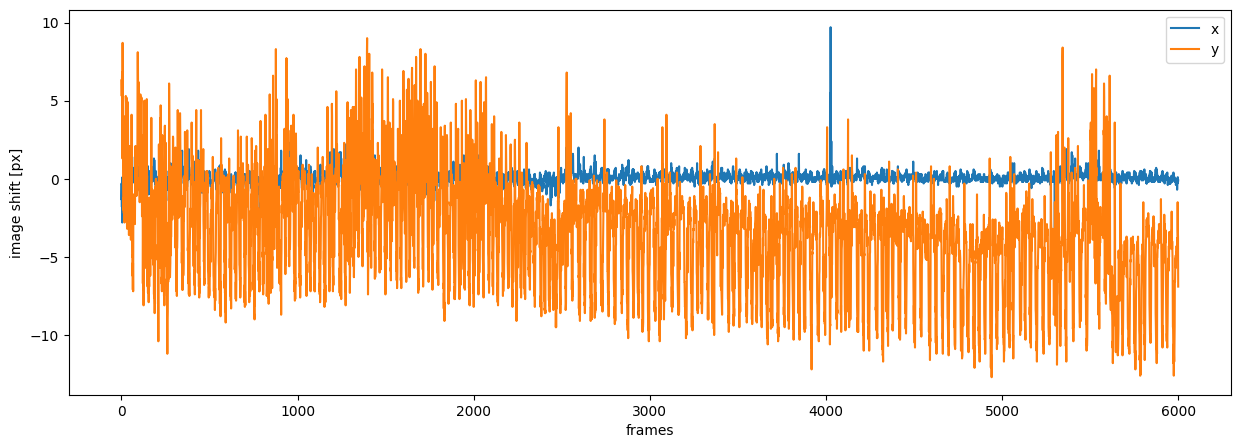

In [154]:
# If there are unreasonable shifts select "doFilter=True".

shift = imp.computeMotionShift(stackMP2, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)
stackMPMC = imp.motionCorrection(stackMP2, shift)

In [155]:
stackMPMC.shape

(6000, 512, 512)

In [ ]:
# To visualize all your volumes
viewer = napari.view_image(stackMPMC)
viewer.window._qt_window.raise_()
viewer.window._qt_window.activateWindow()
viewer.window._qt_window.show()

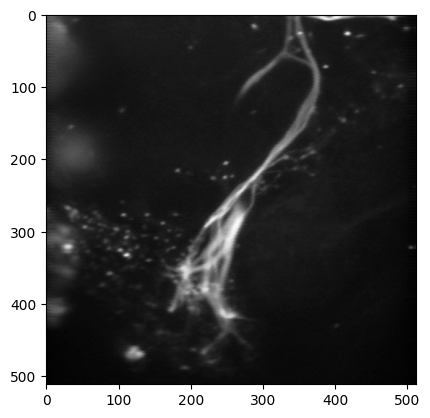

In [157]:
plt.imshow(np.mean(stackMPMC,axis=0), cmap='Greys_r')

Figure saved to: C:\Users\hamida\Documents\Data\Plots\Fly_0006\D\motion_correction_comparison.png


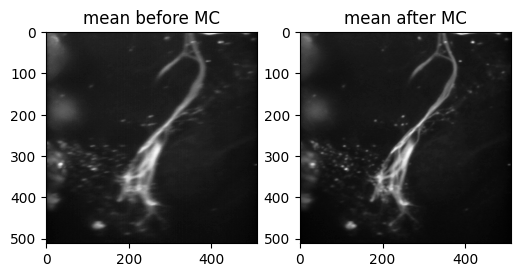

In [159]:
fig,axs = plt.subplots(1,2, figsize=(6,4))

axs[0].imshow(np.mean(stackMP2,axis=0),cmap='Greys_r')
axs[0].set_title('mean before MC')
axs[1].imshow(np.mean(stackMPMC,axis=0), cmap='Greys_r')
axs[1].set_title('mean after MC')



# Ensure plot directory exists
plotDir = os.path.join(rootDir, 'Plots', flyID, trial_folder)
os.makedirs(plotDir, exist_ok=True)

# Save figure
plot_path = os.path.join(plotDir, 'motion_correction_comparison.png')
fig.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Figure saved to: {plot_path}")



Variance map saved to: C:\Users\hamida\Documents\Data\Plots\Fly_0006\D\temporal_variance_map.png


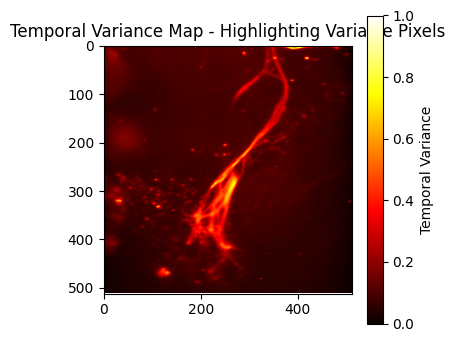

In [160]:
# choose regions of interest:

# stackMPMC: shape (time, x, y) → (6652, 256, 256)
# Example for xarray:
var_image = stackMPMC.var(dim='volumes [s]')  # variance across time
var_np = var_image.values

# Normalize for display
var_norm = (var_np - var_np.min()) / (var_np.max() - var_np.min() + 1e-8)

plt.figure(figsize=(4, 4))
plt.imshow(var_norm, cmap='hot')
plt.colorbar(label='Temporal Variance')
plt.title('Temporal Variance Map - Highlighting Variable Pixels')

# Save before showing
plotDir = os.path.join(rootDir, 'Plots', flyID, trial_folder)
os.makedirs(plotDir, exist_ok=True)
plot_path = os.path.join(plotDir, 'temporal_variance_map.png')
plt.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Variance map saved to: {plot_path}")

plt.show()

In [161]:
stackMPMC.shape

(6000, 512, 512)

In [162]:
# defining rois:
mean_proj_in_time_stackMPMC = np.mean(stackMPMC, axis=0)
# ------------------------------------------
# Open Napari and draw ROI mask
# ------------------------------------------
viewer = napari.view_image(mean_proj_in_time_stackMPMC.values
        , contrast_limits=[mean_proj_in_time_stackMPMC.values.min(),np.percentile(mean_proj_in_time_stackMPMC.values, 99.9)]
        , name='mean_stackMPMC'
        , colormap='gray'
)
# if exists(sep.join([preprocDir,'mask_2d.npy'])):
#     mask = np.load(sep.join([preprocDir,'mask_2d.npy'])) 
#     viewer.add_labels(mask, opacity=0.2)
#     print('exists')

In [163]:
# ------------------------------------------
# Retrieve mask and close viewer
# ------------------------------------------
mask_layer = viewer.layers["mask"]
if mask_layer is None:
    raise ValueError("No mask layer named 'mask' was found in Napari.")
mask_data = mask_layer.data
viewer.close()

# ------------------------------------------
# Save mask as .npy
# ------------------------------------------
# save_dir = os.path.join(preprocDir)
# os.makedirs(save_dir, exist_ok=True)
# mask_path = os.path.join(save_dir, 'mask_2d.npy')
np.save('mask_2d.npy',mask_data)
# print(f"ROI mask saved to: {mask_path}")

C:\Users\hamida\AppData\Local\Temp\ipykernel_18360\892508894.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Reds', len(roi_labels))


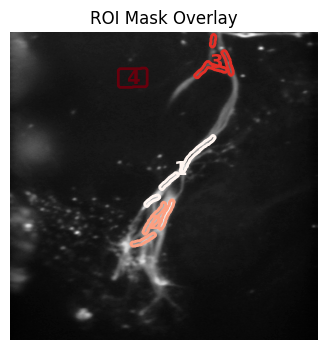

In [164]:
from matplotlib import cm
# ------------------------------------------
# Plot base anatomy with ROI contours & labels
# ------------------------------------------

# Normalize base image for good contrast
base_image = mean_proj_in_time_stackMPMC
base_image_norm = (base_image - base_image.min()) / (base_image.max() - base_image.min() + 1e-8)

# Extract ROI labels
roi_labels = np.unique(mask_data)
roi_labels = roi_labels[roi_labels > 0]  # Exclude background

# Colormap for contours
colors = cm.get_cmap('Reds', len(roi_labels))
#colors = [cm.get_cmap('Reds')(i) for i in np.linspace(0.2, 0.9, len(roi_labels))]

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(base_image_norm, cmap='Greys_r', origin='upper')

# Draw ROI contours and labels
for i, roi in enumerate(roi_labels):
    mask_outline = np.zeros_like(mask_data)
    mask_outline[mask_data == roi] = 1
    ax.contour(mask_outline, levels=[0.5], colors=[colors(i)], linewidths=2)
    
    coords = np.argwhere(mask_data == roi)
    centroid = coords.mean(axis=0)
    ax.text(
        centroid[1], centroid[0], str(int(roi)),
        color=colors(i), fontsize=14, fontweight='bold',
        ha='center', va='center'
    )

ax.set_title('ROI Mask Overlay')
ax.axis('off')

# Save as PNG with high DPI
# overlay_path = os.path.join(save_dir, 'mask_2d_overlay.png')
fig.savefig('mask_2d_overlay.png', bbox_inches='tight', dpi=300)
plt.show()

# print(f"Overlay figure saved to: {overlay_path}")

In [165]:
# plot raw average fluorescence:
# -----------------------------
# Load 2D labeled mask (H x W)
# -----------------------------
# mask_path = os.path.join(preprocDir, 'mask_2d.npy')
roi_mask = np.load('mask_2d.npy')  # values: 0 (bg), 1, 2, ...
# -----------------------------
# Initialize trace matrix
# -----------------------------
roi_labels = np.unique(roi_mask)
roi_labels = roi_labels[roi_labels > 0]  # exclude background
n_rois = len(roi_labels)
n_volumes = stackMPMC.shape[0]
roi_traces = np.zeros((n_rois, n_volumes), dtype=np.float32)
# -----------------------------
# Compute mean trace per ROI
# -----------------------------
for i, roi in enumerate(roi_labels):
    mask = (roi_mask == roi)
    masked_pixels = stackMPMC.values[:, mask]  # shape: (T, N_pixels)
    roi_traces[i] = masked_pixels.mean(axis=1)
print(f"Extracted {n_rois} ROI traces from {n_volumes} volumes.")

Extracted 4 ROI traces from 6000 volumes.


In [166]:
stackMPMC.shape

(6000, 512, 512)

Fluorescence trace figure saved to: C:\Users\hamida\Documents\Data\Plots\Fly_0006\D\roi_raw_fluorescence_traces.png


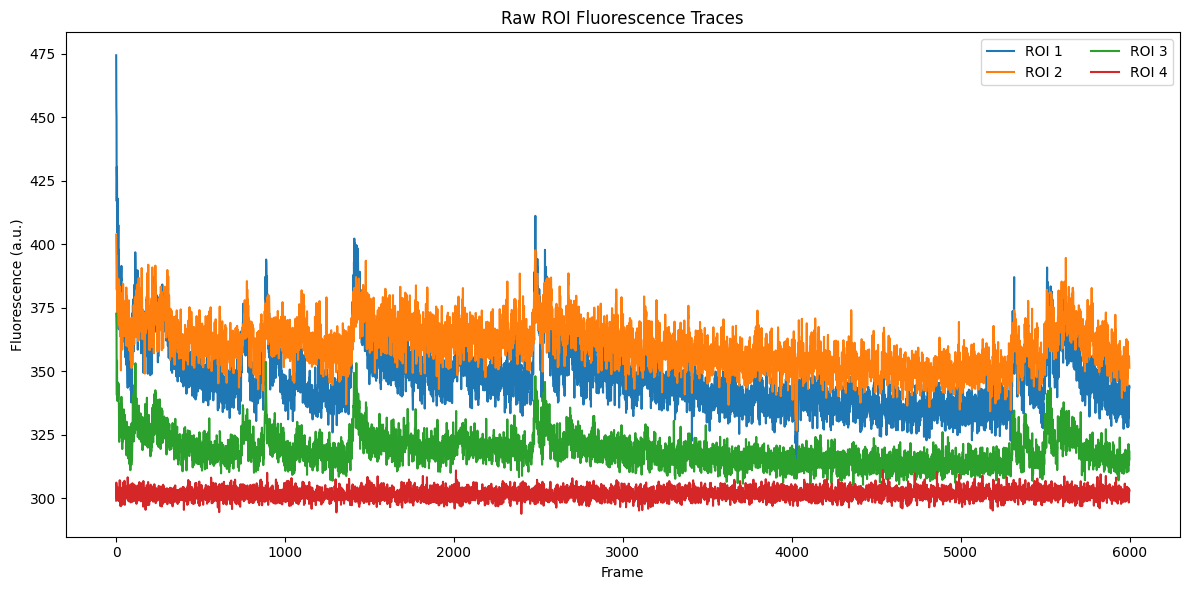

In [167]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(n_rois):
    ax.plot(roi_traces[i], label=f'ROI {roi_labels[i]}')

ax.set_xlabel('Frame')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title('Raw ROI Fluorescence Traces')
ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
# Save 
plotDir = os.path.join(rootDir, 'Plots', flyID, trial_folder)
os.makedirs(plotDir, exist_ok=True)
plot_path = os.path.join(plotDir, 'roi_raw_fluorescence_traces.png')
fig.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Fluorescence trace figure saved to: {plot_path}")

plt.show()

In [168]:
method = 'percentile'
# baseline_window = 10  # Number of frames to use for baseline calculation
percentile_value = 10  # Percentile for baseline calculation if using 'percentile' method


n_rois, n_frames = roi_traces.shape
dff_traces = np.zeros_like(roi_traces, dtype=np.float32)

for i in range(n_rois):
    trace = roi_traces[i]
    if method == 'percentile':
        F0 = np.percentile(trace, percentile_value)
    elif method == 'mean':
        F0 = np.mean(trace[:baseline_window])
    else:
        raise ValueError("method must be 'percentile' or 'mean'")
    
    dff_traces[i] = (trace - F0) / F0

In [169]:
offset_option=False

C:\Users\hamida\AppData\Local\Temp\ipykernel_18360\2730487308.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Reds', n_rois)


Figure saved to: C:\Users\hamida\Documents\Data\Plots\Fly_0006\D\roi_mask_and_dff_traces.png


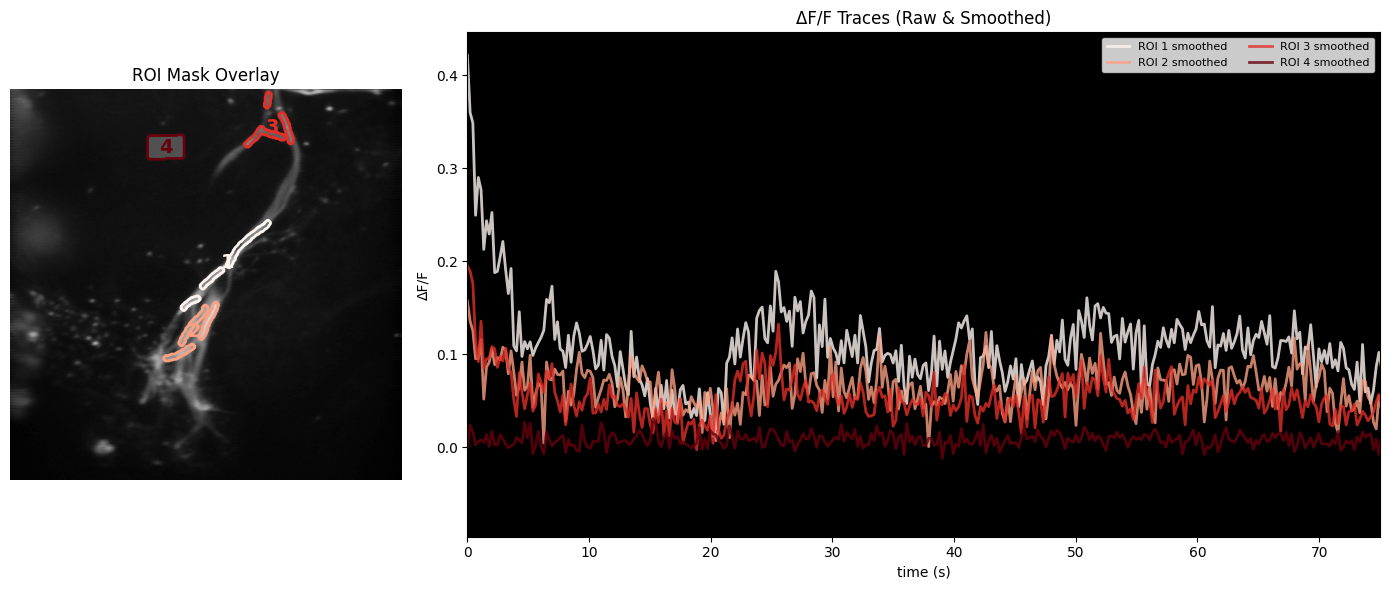

In [170]:
n_rois, n_frames = dff_traces.shape
colors = cm.get_cmap('Reds', n_rois)
volume_times = stackMPMC['volumes [s]'].values

# --------------------------
# Figure: Anatomy + ΔF/F traces
# --------------------------
fig, axes = plt.subplots(
    1, 2, figsize=(14, 6),
    gridspec_kw={'width_ratios': [0.3, 0.7]}
)

# --------------------------
# Subplot 1: ROI mask overlay on anatomy
# --------------------------
ax1 = axes[0]
ax1.imshow(mean_proj_in_time_stackMPMC, cmap='Greys_r', origin='upper')
ax1.imshow(mask_data, cmap='gray', alpha=0.25)  # faded base mask

# Overlay ROI contours and centroids
for i, roi in enumerate(roi_labels):
    coords = np.argwhere(mask_data == roi)
    centroid = coords.mean(axis=0)
    mask_outline = np.zeros_like(mask_data)
    mask_outline[mask_data == roi] = 1
    ax1.contour(mask_outline, levels=[0.5], colors=[colors(i)], linewidths=2)
    ax1.text(
        centroid[1], centroid[0], str(int(roi)),
        color=colors(i), fontsize=14, fontweight='bold',
        ha='center', va='center'
    )

ax1.set_title('ROI Mask Overlay')
ax1.axis('off')

# --------------------------
# Subplot 2: ΔF/F traces with smoothed overlay
# --------------------------
ax2 = axes[1]

if offset_option:
    offset = 1.5
    for i in range(n_rois):
        raw_trace = dff_traces[i]
        smooth_trace = dff_traces[i]
        color = colors(i)

        # Raw
        # ax2.plot(volume_times, raw_trace + i * offset,
        #          color=color, label=f'ROI {roi_labels[i]} raw', linewidth=1)

        # Smoothed
        ax2.plot(volume_times, smooth_trace + i * offset,
                 color=color, linestyle='-', linewidth=2, alpha=0.8,
                 label=f'ROI {roi_labels[i]} smoothed')

    ax2.set_yticks([i * offset for i in range(n_rois)])
    ax2.set_yticklabels([f'ROI {r}' for r in roi_labels])
    ax2.set_ylabel('ΔF/F + offset')

else:
    for i in range(n_rois):
        raw_trace = dff_traces[i]
        smooth_trace = dff_traces[i]
        color = colors(i) if n_rois > 1 else 'yellow'

        # Raw
        # ax2.plot(volume_times, raw_trace,
        #          label=f'ROI {roi_labels[i]} raw',
        #          color=color, linewidth=1)

        # Smoothed
        ax2.plot(volume_times, smooth_trace,
                 label=f'ROI {roi_labels[i]} smoothed',
                 color=color, linestyle='-', linewidth=2, alpha=0.8)

    ax2.set_ylabel('ΔF/F')

ax2.set_title('ΔF/F Traces (Raw & Smoothed)')
ax2.set_xlabel('time (s)')
ax2.set_xlim([0, 75])  # adjust to your range
ax2.legend(loc='upper right', ncol=2, fontsize=8)
ax2.set_facecolor('black') # makes background black

plt.tight_layout()

# --------------------------
# Save the figure to plotDir
# --------------------------

# Construct the plot directory path
plotDir = os.path.join(rootDir, 'Plots', flyID, trial_folder)
# Create the plot directory if it doesn't exist
os.makedirs(plotDir, exist_ok=True)

plot_path = os.path.join(plotDir, 'roi_mask_and_dff_traces.png')
fig.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Figure saved to: {plot_path}")

plt.show()

plt.show()